In [ ]:
!sudo apt-get update
!apt install imagemagick

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,009 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,669 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main am

In [ ]:
!pip install 'gym[all]' pygame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 15.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.p

In [ ]:
import numpy as np
import gym
import os
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque
from IPython.display import Image
from matplotlib import animation
from tqdm.notebook import tqdm

In [ ]:
env_id = 'LunarLander-v2'
env = gym.make(
    env_id, 
    new_step_api=True
)
eval_env = gym.make(
    env_id, 
    new_step_api=True, 
    render_mode='rgb_array'
)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [ ]:
h_size = 128
n_training_episodes = 3000
n_eval_episodes = 10
max_steps = 1000
gamma = 0.99
lr = 1e-3
eval_seed = range(n_eval_episodes)

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size * 2)
        self.fc3 = nn.Linear(h_size * 2, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()

        return action.item(), m.log_prob(action)

In [ ]:
def reinforce(
    policy, 
    optimizer, 
    n_training_episodes, 
    max_steps, 
    gamma, 
    print_every
):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_steps):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, info = env.step(action)
            rewards.append(reward)
            if done:
                break
                
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen=max_steps)
        n_steps = len(rewards)

        for t in range(n_steps)[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * disc_return_t + rewards[t])

        eps = np.finfo(np.float32).eps.item()

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))

    return scores

In [ ]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

policy = Policy(
    s_size=state_space,
    a_size=action_space,
    h_size=h_size,
).to(device)

optimizer = optim.Adam(policy.parameters(), lr=lr)

In [ ]:
scores = reinforce(
    policy,
    optimizer,
    n_training_episodes,
    max_steps,
    gamma,
    print_every=100
)

Episode 100	Average Score: -181.18
Episode 200	Average Score: -190.75
Episode 300	Average Score: -69.88
Episode 400	Average Score: -77.69
Episode 500	Average Score: -6.60
Episode 600	Average Score: -10.15
Episode 700	Average Score: 46.37
Episode 800	Average Score: 19.47
Episode 900	Average Score: 67.07
Episode 1000	Average Score: 85.87
Episode 1100	Average Score: 106.18
Episode 1200	Average Score: 47.55
Episode 1300	Average Score: -48.71
Episode 1400	Average Score: 95.72
Episode 1500	Average Score: 46.86
Episode 1600	Average Score: 149.47
Episode 1700	Average Score: 85.36
Episode 1800	Average Score: 40.65
Episode 1900	Average Score: 159.25
Episode 2000	Average Score: 81.12
Episode 2100	Average Score: -43.80
Episode 2200	Average Score: -60.01
Episode 2300	Average Score: 148.17
Episode 2400	Average Score: 207.73
Episode 2500	Average Score: 241.99
Episode 2600	Average Score: 217.04
Episode 2700	Average Score: 196.28
Episode 2800	Average Score: 209.88
Episode 2900	Average Score: 211.99
Epi

In [ ]:
def evaluate_agent(
    env, 
    max_steps, 
    n_eval_episodes, 
    policy,
    seed
):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        if seed:
            state = env.reset(seed=seed[episode])
        else:
            state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, _, info = env.step(action)
            total_rewards_ep += reward

            if done:
                break

            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [ ]:
mean_reward, std_reward = evaluate_agent(
    eval_env, 
    max_steps, 
    n_eval_episodes,
    policy,
    eval_seed
)

print(f"Mean_reward={mean_reward:.4f} +/- {std_reward:.4f}")

Mean_reward=221.2932 +/- 53.8300


In [ ]:
def save_frames_as_gif(
    frames, 
    path='./', 
    filename='demo.gif',
    fps=20
):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=fps)
    plt.close()

Total rewards: 228.55071229835983


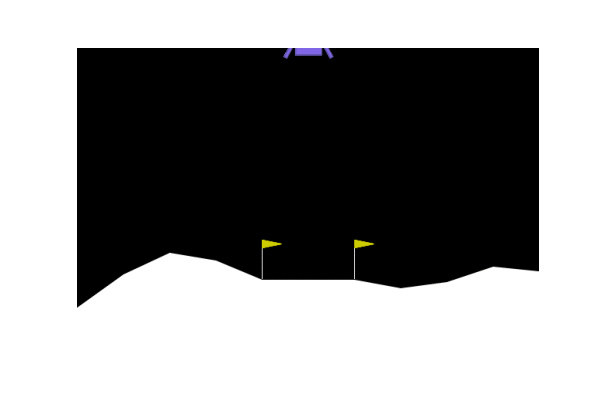

In [ ]:
def record_video(
    env,
    policy
):
    images = []  
    terminated = False
    truncated = False

    state = env.reset(seed=np.random.randint(0,500))
    img = env.render()
    images.append(img[0])
    total_rewards = 0

    while not terminated or truncated:
        action, _ = policy.act(state) 
        state, reward, terminated, truncated, info = env.step(action)
        total_rewards += reward
        img = env.render()
        images.append(img[0])

    save_frames_as_gif(images)

    print('Total rewards:', total_rewards)

record_video(
    eval_env,
    policy
)

Image(open('demo.gif','rb').read())